In [667]:
import pywt
import ta
from operator import itemgetter
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import coint
import sys
import pandas as pd
from matplotlib import pyplot
# sys.path.append('/home/ubuntu/auquantoolbox')
# from backtester.dataSource.yahoo_data_source import YahooStockDataSource

%matplotlib inline

In [668]:

# instrumentIds = list(set(['ITOT', 'ACWI', 'IWV', 'VT', 'VTI',
#                  'DIA', 'RSP', 'IOO', 'IVV', 'SPY',
#                  'SHE', 'IWM', 'OEF', 'QQQ',
#                  'CVY', 'RPG', 'RPV', 'IWB', 'IWF', 
#                  'IWD', 'IVW', 'IVE', 'PKW', 
#                  'PRF', 'SDY', 'VV', 'VUG', 
#                  'VTV', 'MGC', 'MGK', 'MGV', 'VIG', 
#                  'VYM', 'DTN', 'DLN', 'MDY', 'DVY', 
#                  'IWR', 'IWP', 'IWS', 'IJH', 'IJK', 
#                  'IJJ', 'PDP', 'DON', 'IWC', 'IWM', 
#                  'IWO', 'IWN', 'IJR', 'IJT', 'IJS', 
#                  'EEB', 'IDV', 'ACWX', 'BKF', 'EFA', 
#                  'EFG', 'EFV', 'SCZ', 'EEM', 'PID', 
#                  'DWX', 'DEM', 'DGS', 'AAXJ', 'EZU', 
#                  'EPP', 'IEV', 'ILF', 'FEZ', 'VGK', 
#                  'VPL', 'DFE', 'EWA', 'EWC', 'EWG', 
#                  'EWI', 'EWJ', 'EWD', 'EWL', 'EWP', 
#                  'EWU', 'DXJ', 'EWZ', 'FXI', 'EWH', 
#                  'EWW', 'RSX', 'EWS', 'EWM','EWY', 
#                  'EWT', 'EPI', 'XLY', 'IYC', 'ITB', 
#                  'XHB', 'VCR','XLP', 'IYK', 'VDC', 
#                  'XLE', 'IYE', 'IGE', 'OIH', 'XOP', 
#                  'VDE', 'QCLN', 'XLF','IYF', 'KBE', 
#                  'KRE', 'VFH']))
# ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
#                             dataSetId=dataSetId,
#                             instrumentIds=instrumentIds,
#                             startDateStr=startDateStr,
#                             endDateStr=endDateStr,
#                             event='history')
# data_close = ds.getBookDataByFeature()['close']
# data_open = ds.getBookDataByFeature()['open']
# data_high = ds.getBookDataByFeature()['high']
# data_low = ds.getBookDataByFeature()['low']
# data_vol = ds.getBookDataByFeature()['volume'] 

In [669]:
import datetime
import random
import yfinance as yf

# Define the date for which you want to fetch the data
start_date = datetime.datetime(2014, 3, 29)
end_date = datetime.datetime(2024, 3, 29)

# List of 50 random Yahoo Finance ticker symbols
ticker_symbols = list(set(['GOOG','GOOGL']))

# Shuffle the ticker symbols to randomize the selection
random.shuffle(ticker_symbols)

# Fetch data for each ticker symbol
data = {}
for symbol in ticker_symbols:
    try:
        ticker = yf.Ticker(symbol)
        hist = ticker.history(start=start_date, end=end_date)
        hist.reset_index(inplace=True)

        if not hist.empty:
            data[symbol] = {
                'Date':hist['Date'].to_numpy(),
                'Open': hist['Open'].to_numpy(),
                'High': hist['High'].to_numpy(),
                'Low': hist['Low'].to_numpy(),
                'Close': hist['Close'].to_numpy(),
                'Volume': hist['Volume'].to_numpy(),
            }
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")

# Print the data
for symbol, prices in data.items():
    print(f"{symbol}: {prices}")


GOOG: {'Date': array([Timestamp('2014-03-31 00:00:00-0400', tz='America/New_York'),
       Timestamp('2014-04-01 00:00:00-0400', tz='America/New_York'),
       Timestamp('2014-04-02 00:00:00-0400', tz='America/New_York'), ...,
       Timestamp('2024-03-26 00:00:00-0400', tz='America/New_York'),
       Timestamp('2024-03-27 00:00:00-0400', tz='America/New_York'),
       Timestamp('2024-03-28 00:00:00-0400', tz='America/New_York')],
      dtype=object), 'Open': array([ 28.26689339,  27.8590126 ,  29.91736221, ..., 151.24000549,
       152.14500427, 152.        ]), 'High': array([ 28.27237892,  28.34468079,  30.15869904, ..., 153.19999695,
       152.69000244, 152.66999817]), 'Low': array([ 27.77025795,  27.8590126 ,  28.03253746, ..., 151.02999878,
       150.13000488, 151.33000183]), 'Close': array([ 27.77225113,  28.28035545,  28.27237892, ..., 151.69999695,
       151.94000244, 152.25999451]), 'Volume': array([  216593,   158434,  2942055, ..., 19312700, 16622000, 21105600],
      dty

In [670]:
data

{'GOOG': {'Date': array([Timestamp('2014-03-31 00:00:00-0400', tz='America/New_York'),
         Timestamp('2014-04-01 00:00:00-0400', tz='America/New_York'),
         Timestamp('2014-04-02 00:00:00-0400', tz='America/New_York'), ...,
         Timestamp('2024-03-26 00:00:00-0400', tz='America/New_York'),
         Timestamp('2024-03-27 00:00:00-0400', tz='America/New_York'),
         Timestamp('2024-03-28 00:00:00-0400', tz='America/New_York')],
        dtype=object),
  'Open': array([ 28.26689339,  27.8590126 ,  29.91736221, ..., 151.24000549,
         152.14500427, 152.        ]),
  'High': array([ 28.27237892,  28.34468079,  30.15869904, ..., 153.19999695,
         152.69000244, 152.66999817]),
  'Low': array([ 27.77025795,  27.8590126 ,  28.03253746, ..., 151.02999878,
         150.13000488, 151.33000183]),
  'Close': array([ 27.77225113,  28.28035545,  28.27237892, ..., 151.69999695,
         151.94000244, 152.25999451]),
  'Volume': array([  216593,   158434,  2942055, ..., 1931270

In [671]:
class YahooDataSource:

    def __init__(self,start_date,end_date,tickers,columns):
        self.tickers = tickers
        self.columns = columns
        self.start_date = start_date
        self.end_date = end_date
        self.data  = self.get_yahoo_data()

    def get_yahoo_data(self):

        data = {}
        for symbol in ticker_symbols:
            
            try:
                ticker = yf.Ticker(symbol)
                hist = ticker.history(start=start_date, end=end_date)
                hist.reset_index(inplace=True)
                if not hist.empty:
                    for col in self.columns:
                        data[symbol + "_" + col] = hist[col].to_numpy()
            except Exception as e:
                print(f"Error fetching data for {symbol}: {e}")

        return data
    
    def get_data_by_column_tickers(self,columns=-1,tickers=-1):
        
        all_tickers = self.tickers
        all_columns = self.columns

        if columns ==-1:
            columns = all_columns
        
        if tickers == -1:
            tickers = all_tickers
        
        validated_tickers = set(tickers).intersection(all_tickers)
        validated_columns = set(columns).intersection(all_columns)

        ticker_columns = self.create_ticker_columns(validated_columns,validated_tickers)

        return pd.DataFrame({key: self.data[key] for key in ticker_columns})
    
    def create_ticker_columns(self,columns,tickers):

        ticker_columns = []
        for tick in tickers:
            for col in columns:
                name = tick+"_"+col
                ticker_columns.append(name)

        return ticker_columns
    
    def get_tickers(self,ticker_columns):

        return [i.split("_")[0] for i in ticker_columns]

    
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = {}
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs[(keys[i], keys[j])] = result
    return score_matrix, pvalue_matrix, pairs

In [676]:
start_date = datetime.datetime(2014, 3, 29)
end_date = datetime.datetime(2024, 3, 29)
tickers  =  ["GOOGL","GOOG"]
columns =   ["High","Close","Low","Volume"]
ds = YahooDataSource(start_date,end_date,tickers,columns)

In [677]:
df = ds.get_data_by_column_tickers(columns=columns,tickers=-1)

In [678]:
df

,GOOG_Volume,GOOG_High,GOOG_Low,GOOG_Close,GOOGL_Volume,GOOGL_High,GOOGL_Low,GOOGL_Close
0,216593,28.272379,27.770258,27.772251,77614308,28.403402,27.849098,27.890640
1,158434,28.344681,27.859013,28.280355,87152760,28.465965,27.977978,28.400652
2,2942055,30.158699,28.032537,28.272379,83360556,28.648649,28.128128,28.405907
3,101983228,29.283602,28.129271,28.409002,80366000,29.415001,28.300501,28.575001
4,127386783,28.809404,27.075665,27.082645,107274000,28.986000,27.224501,27.262501
...,...,...,...,...,...,...,...,...
2512,19226300,152.559998,150.089996,151.770004,29175700,151.580002,148.979996,150.770004
2513,15114700,151.455994,148.800003,151.149994,19229300,150.380005,147.820007,150.070007
2514,19312700,153.199997,151.029999,151.699997,22149100,152.259995,149.979996,150.669998
2515,16622000,152.690002,150.130005,151.940002,22879200,151.639999,148.899994,150.869995


In [674]:
data_close = pd.DataFrame()
data_open = pd.DataFrame()
data_vol = pd.DataFrame()
data_low = pd.DataFrame()
data_high = pd.DataFrame()

In [675]:
data_close["GOOG"] = data['GOOG']["Close"]
data_close["GOOGL"] = data['GOOGL']["Close"]

data_open["GOOG"] = data['GOOG']["Open"]
data_open["GOOGL"] = data['GOOGL']["Open"]

data_vol["GOOG"] = data['GOOG']["Volume"]
data_vol["GOOGL"] = data['GOOGL']["Volume"]

data_low["GOOG"] = data['GOOG']["Low"]
data_low["GOOGL"] = data['GOOGL']["Low"]
   
data_high["GOOG"] = data['GOOG']["High"]
data_high["GOOGL"] = data['GOOGL']["High"]
    

In [621]:
# Checking for any null values in data
d = data_close.isnull().any()
print(d[d == True])

Series([], dtype: bool)


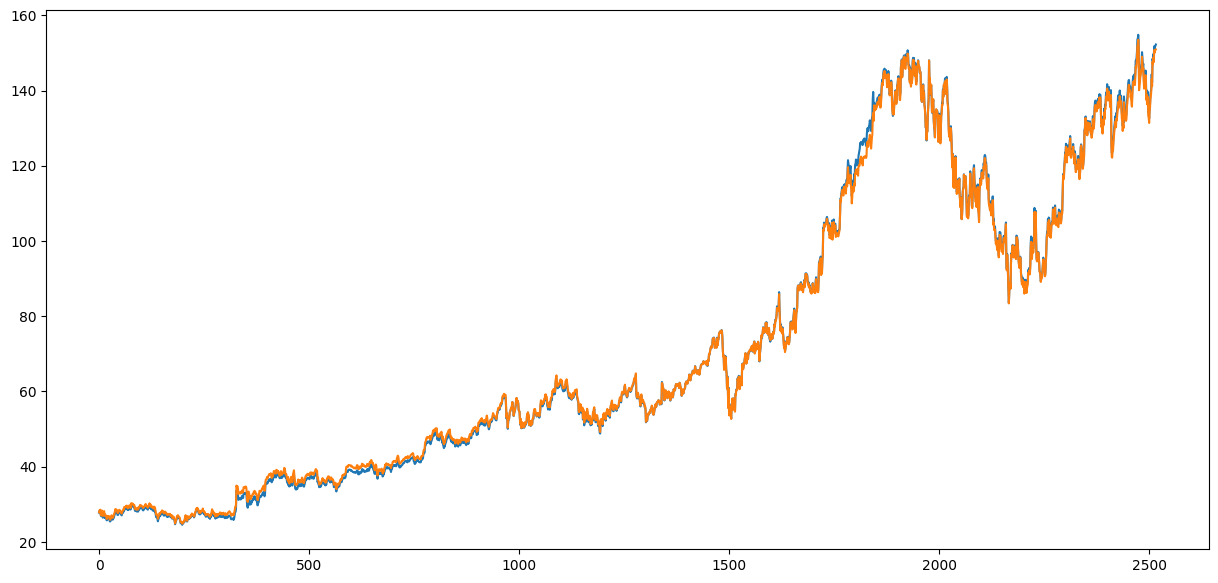

In [622]:
# Create a plot of the time series to visualize the data
for i in range(0,data_close.shape[1]):
    S = data_close.iloc[:, i]
    S.plot(figsize=(15,7))

In [661]:

scores, pvalues, pairs = find_cointegrated_pairs(df)

MissingDataError: exog contains inf or nans

In [659]:
pairs_data = {key:value[1]  for (key, value) in pairs.items()}
pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])

In [660]:
pairs_data

[(('GOOG_Close', 'GOOGL_Close'), 0.00047794793045840916)]

In [646]:
tickers = ds.get_tickers(pairs_data[0][0])

In [634]:
[i.split("_") for i in pairs_data[0][0]]

[['GOOG_Close'], ['GOOGL_Close']]

In [647]:
df=ds.get_data_by_column_tickers(columns=["Close","High"],tickers=tickers)

,GOOG_High,GOOG_Close,GOOGL_High,GOOGL_Close
0,28.272379,27.772251,28.403402,27.890640
1,28.344681,28.280355,28.465965,28.400652
2,30.158699,28.272379,28.648649,28.405907
3,29.283602,28.409002,29.415001,28.575001
4,28.809404,27.082645,28.986000,27.262501
...,...,...,...,...
2512,152.559998,151.770004,151.580002,150.770004
2513,151.455994,151.149994,150.380005,150.070007
2514,153.199997,151.699997,152.259995,150.669998
2515,152.690002,151.940002,151.639999,150.869995


<Axes: >

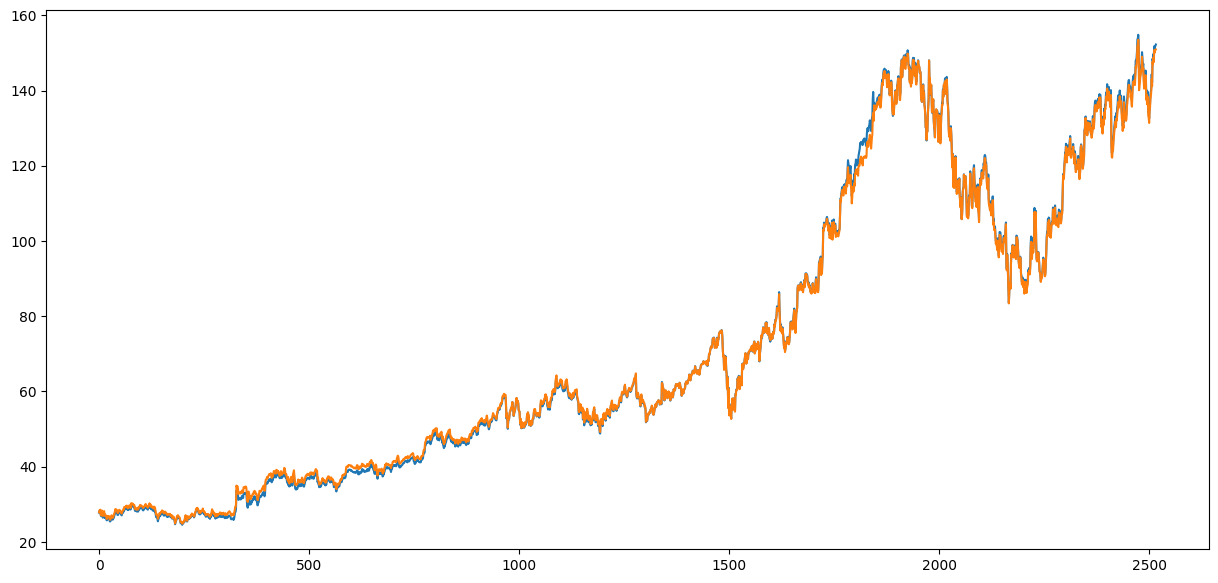

In [166]:
pair_data = pd.DataFrame({'S1_close':data_close['GOOG'],'S2_close':data_close['GOOGL']
                         ,'S1_open':data_open['GOOG'],'S2_open':data_open['GOOGL']
                         ,'S1_high':data_high['GOOG'],'S2_high':data_high['GOOGL']
                         ,'S1_low':data_low['GOOG'],'S2_low':data_low['GOOGL']
                         ,'S1_volume':data_vol['GOOG'],'S2_volume':data_vol['GOOGL']})
pair_data['S1_close'].plot(figsize=(15,7))
pair_data['S2_close'].plot(figsize=(15,7))

In [699]:
class TechnicalFeatures:

    def __init__(self,data):
        self.data = data

    def create_suffix(self,column,suffix):
        return column + '_'+suffix

    def rsi(self,window = 14,columns=[],suffix='rsi',inplace = True):

        data = self.data
        new_data = pd.DataFrame()
        
        for col in columns:
            name = self.create_suffix(col,suffix)
            if inplace == True:
                data[name] = ta.momentum.RSIIndicator(data[col], window=window).rsi()
            else:
                new_data[name] = ta.momentum.RSIIndicator(data[col], window=window).rsi()

        if inplace == True:
            return data
        else:
            return new_data


    def money_flow_index(self,window = 14,tickers=[],suffix='mfi',inplace = True):

        data = self.data
        new_data = pd.DataFrame()

        for i in tickers:

            high_column = i + "_" + "High"
            low_column = i + "_" + "Low"
            close_column = i + "_" + "Close"
            volume_column = i + "_" + "Volume"

            name = self.create_suffix(i,suffix)
            if inplace == True:
                data[name] =  ta.volume.money_flow_index(data[high_column],data[low_column],data[close_column],data[volume_column],window=window)
            else:
                new_data[name] = ta.volume.money_flow_index(data[high_column],data[low_column],data[close_column],data[volume_column],window=window)

        if inplace == True:
            return data
        else:
            return new_data
        

    def acc_dist_index(self,tickers=[],suffix='adi',inplace = True):

        data = self.data
        new_data = pd.DataFrame()

        for i in tickers:

            high_column = i + "_" + "High"
            low_column = i + "_" + "Low"
            close_column = i + "_" + "Close"
            volume_column = i + "_" + "Volume"

            name = self.create_suffix(i,suffix)
            if inplace == True:
                data[name] =  ta.volume.acc_dist_index(data[high_column],data[low_column],data[close_column],data[volume_column])
            else:
               new_data[name] = ta.volume.acc_dist_index(data[high_column],data[low_column],data[close_column],data[volume_column])

        if inplace == True:
            return data
        else:
            return new_data
        
    def volume_price_trend(self,tickers=[],suffix='vpt',inplace = True):

        data = self.data
        new_data = pd.DataFrame()

        for i in tickers:

            close_column = i + "_" + "Close"
            volume_column = i + "_" + "Volume"

            name = self.create_suffix(i,suffix)
            if inplace == True:
                data[name] =  ta.volume.volume_price_trend(data[close_column],data[volume_column])
            else:
               new_data[name] = ta.volume.volume_price_trend(data[close_column],data[volume_column])

        if inplace == True:
            return data
        else:
            return new_data
        

    def average_true_range(self,window = 14,tickers=[],suffix='atr',inplace = True):

        data = self.data
        new_data = pd.DataFrame()

        for i in tickers:

            high_column = i + "_" + "High"
            low_column = i + "_" + "Low"
            close_column = i + "_" + "Close"

            name = self.create_suffix(i,suffix)
            if inplace == True:
                data[name] =  ta.volatility.average_true_range(data[high_column],data[low_column],data[close_column],window=window)
            else:
               new_data[name] = ta.volatility.average_true_range(data[high_column],data[low_column],data[close_column],window=window)

        if inplace == True:
            return data
        else:
            return new_data
        
    

    def bollinger_mavg(self,window = 14,columns=[],suffix='bmavg',inplace = True):

        data = self.data
        new_data = pd.DataFrame()
        
        for col in columns:
            name = self.create_suffix(col,suffix)
            if inplace == True:
                data[name] = ta.volatility.bollinger_mavg(data[col], window=window)
            else:
                new_data[name] = ta.volatility.bollinger_mavg(data[col], window=window)
        if inplace == True:
            return data
        else:
            return new_data
        
    def average_directional_movement_index(self,window=14,tickers=[],suffix='adx',inplace=True):

        data = self.data
        new_data = pd.DataFrame()

        for i in tickers:

            high_column = i + "_" + "High"
            low_column = i + "_" + "Low"
            close_column = i + "_" + "Close"

            name = self.create_suffix(i,suffix)
            if inplace == True:
                data[name] =  ta.trend.adx(data[high_column],data[low_column],data[close_column],window=window)
            else:
               new_data[name] = ta.trend.adx(data[high_column],data[low_column],data[close_column],window=window)

        if inplace == True:
            return data
        else:
            return new_data

    def exponational_moving_average(self,window = 14,columns=[],suffix='ema',inplace = True):

        data = self.data
        new_data = pd.DataFrame()

        for col in columns:
            name = self.create_suffix(col,suffix)
            if inplace == True:
                data[name] = ta.trend.ema_indicator(data[col], window=window)
            else:
                new_data[name] = ta.trend.ema_indicator(data[col], window=window)
        if inplace == True:
            return data
        else:
            return new_data
        
    def log_return(self,columns=[],suffix="logrtn",inplace=True):

        data = self.data
        new_data = pd.DataFrame()

        for col in columns:
            name = self.create_suffix(col,suffix)
            if inplace == True:
                data[name] = ta.others.daily_log_return(data[col])
            else:
                new_data[name] = ta.others.daily_log_return(data[col])
                
        if inplace == True:
            return data
        else:
            return new_data
        

In [701]:
ts = TechnicalFeatures(df)
df = ts.money_flow_index(tickers = ["GOOGL","GOOG"])
df = ts.acc_dist_index(tickers = ["GOOGL","GOOG"])
df = ts.volume_price_trend(tickers = ["GOOGL","GOOG"])
df = ts.average_true_range(tickers = ["GOOGL","GOOG"])
df = ts.average_directional_movement_index(tickers = ["GOOGL","GOOG"])
df = ts.log_return(columns=['GOOGL_Close','GOOG_Close'])
df = ts.exponational_moving_average(columns=['GOOGL_Close','GOOG_Close'])
df = ts.bollinger_mavg(columns=['GOOGL_Close','GOOG_Close'])
df = ts.rsi(columns=['GOOGL_Close','GOOG_Close'])

In [167]:
# add technical indicators
# 1. Momentum Indicators
# Relative Strength Index
pair_data['S1_rsi'] = ta.momentum.RSIIndicator(pair_data['S1_close'], window=14).rsi()
pair_data['S2_rsi'] = ta.momentum.RSIIndicator(pair_data['S2_close'], window=14).rsi()
# Money Flow Index
pair_data['S1_mfi'] = ta.volume.money_flow_index(pair_data['S1_high'], pair_data['S1_low'], 
                                                   pair_data['S1_close'], pair_data['S1_volume'], window=14)
pair_data['S2_mfi'] = ta.volume.money_flow_index(pair_data['S2_high'], pair_data['S2_low'], 
                                                   pair_data['S2_close'], pair_data['S2_volume'], window=14)

# 2. Volume Indicators
# Accumulation/Distribution Index (ADI)
pair_data['S1_adi'] = ta.volume.acc_dist_index(pair_data['S1_high'], pair_data['S1_low'], pair_data['S1_close'], pair_data['S1_volume'])
pair_data['S2_adi'] = ta.volume.acc_dist_index(pair_data['S2_high'], pair_data['S2_low'], pair_data['S2_close'], pair_data['S2_volume'])
# Volume-price trend (VPT)
pair_data['S1_vpt'] = ta.volume.volume_price_trend(pair_data['S1_close'], pair_data['S1_volume'])
pair_data['S2_vpt'] = ta.volume.volume_price_trend(pair_data['S2_close'], pair_data['S2_volume'])

# 3. Volatility Indicators
# Average True Range (ATR)
pair_data['S1_atr'] = ta.volatility.average_true_range(pair_data['S1_high'], pair_data['S1_low'], 
                                                       pair_data['S1_close'], window=14)
pair_data['S2_atr'] = ta.volatility.average_true_range(pair_data['S2_high'], pair_data['S2_low'], 
                                                       pair_data['S2_close'], window=14)
# Bollinger Bands (BB) N-period simple moving average (MA)
pair_data['S1_bb_ma'] = ta.volatility.bollinger_mavg(pair_data['S1_close'], window=20)
pair_data['S2_bb_ma'] = ta.volatility.bollinger_mavg(pair_data['S2_close'], window=20)

# 4. Trend Indicators
# Average Directional Movement Index (ADX)
pair_data['S1_adx'] = ta.trend.adx(pair_data['S1_high'], pair_data['S1_low'], pair_data['S1_close'], window=14)
pair_data['S2_adx'] = ta.trend.adx(pair_data['S2_high'], pair_data['S2_low'], pair_data['S2_close'], window=14)
# Exponential Moving Average
pair_data['S1_ema'] = ta.trend.ema_indicator(pair_data['S1_close'], window=14)
pair_data['S2_ema'] = ta.trend.ema_indicator(pair_data['S2_close'], window=14)
# Moving Average Convergence Divergence (MACD)
# pair_data['S1_macd'] = ta.trend.macd_diff(pair_data['S1_close'], window_fast=14, window_slow=30)
# pair_data['S2_macd'] = ta.trend.macd_diff(pair_data['S2_close'], window_fast=14, window_slow=30)

# 5. Other Indicators
# Daily Log Return (DLR)
pair_data['S1_dlr'] = ta.others.daily_log_return(pair_data['S1_close'])
pair_data['S2_dlr'] = ta.others.daily_log_return(pair_data['S2_close'])

In [168]:
est = sm.OLS(pair_data.S1_close, pair_data.S2_close)
est = est.fit()


In [169]:
est.params

S2_close    1.003196
dtype: float64

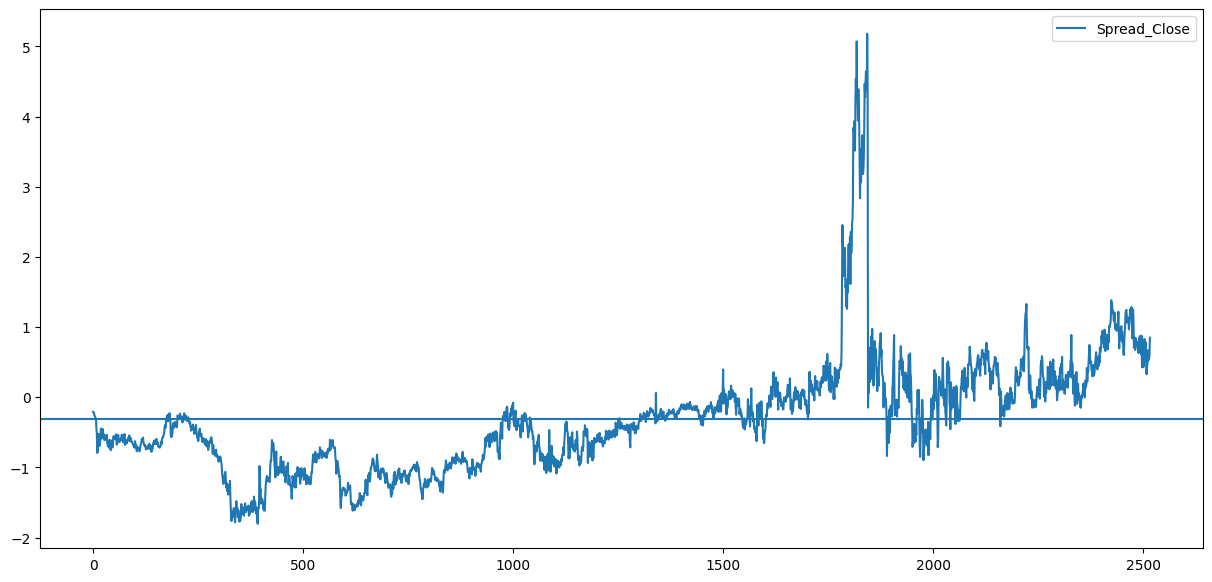

In [705]:
alpha = -est.params.iloc[0]
pair_data['Spread_Close'] = pair_data.S1_close + (pair_data.S2_close * alpha)
pair_data['Spread_Close'].plot(figsize=(15,7))
pyplot.axhline(pair_data['Spread_Close'].mean())
pyplot.legend(['Spread_Close'])

In [171]:
est_op = sm.OLS(pair_data.S1_open, pair_data.S2_open)
est_op = est_op.fit()
alpha_op = -est_op.params[0]
pair_data['Spread_Open'] = pair_data.S1_open + (pair_data.S2_open * alpha_op)
est_hi = sm.OLS(pair_data.S1_high, pair_data.S2_high)
est_hi = est_hi.fit()
alpha_hi = -est_hi.params[0]
pair_data['Spread_High'] = pair_data.S1_high + (pair_data.S2_high * alpha_hi)
est_lo = sm.OLS(pair_data.S1_low, pair_data.S2_low)
est_lo = est_lo.fit()
alpha_lo = -est_lo.params[0]
pair_data['Spread_Low'] = pair_data.S1_low + (pair_data.S2_low * alpha_lo)

C:\Users\aayus\AppData\Local\Temp\ipykernel_2284\3666873934.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_op = -est_op.params[0]
C:\Users\aayus\AppData\Local\Temp\ipykernel_2284\3666873934.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_hi = -est_hi.params[0]
C:\Users\aayus\AppData\Local\Temp\ipykernel_2284\3666873934.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_lo = -est_lo.params[0]


In [706]:
def wav_den(ts_orig):
    print("Before Denosing",len(ts_orig))
    (ca, cd) = pywt.dwt(ts_orig, 'db8')
    cat = pywt.threshold(ca, np.std(ca)/8, mode='soft')
    cdt = pywt.threshold(cd, np.std(cd)/8, mode='soft')
    ts_rec = pywt.idwt(cat, cdt, 'db8')
    print("After Denosing",len(ts_rec))
    return ts_rec[1:]

In [707]:
#Use MinMaxScaler to normalize Weighted Price to range from 0 to 1
cols = ['Spread_Close', 'Spread_Open', 'Spread_High', 'Spread_Low', 'S1_volume',
                                          'S2_volume', 'S1_rsi', 'S2_rsi', 'S1_mfi', 'S2_mfi', 'S1_adi', 'S2_adi',
                                           'S1_vpt', 'S2_vpt', 'S1_atr', 'S2_atr', 'S1_bb_ma', 'S2_bb_ma', 'S1_adx',
                                            'S2_adx', 'S1_ema', 'S2_ema', 'S1_dlr', 'S2_dlr']
                                          #  'S2_adx', 'S1_ema', 'S2_ema', 'S1_macd', 'S2_macd', 'S1_dlr', 'S2_dlr']
lstm_pair_data = pd.DataFrame({'Spread_Close':pair_data['Spread_Close'][30:],
                               'Spread_Open':pair_data['Spread_Open'][30:],
                               'Spread_High':pair_data['Spread_High'][30:],
                               'Spread_Low':pair_data['Spread_Low'][30:],
                               'S1_volume':pair_data['S1_volume'][30:],
                               'S2_volume':pair_data['S2_volume'][30:],
                               'S1_rsi':pair_data['S1_rsi'][30:],
                               'S2_rsi':pair_data['S2_rsi'][30:],
                               'S1_mfi':pair_data['S1_mfi'][30:],
                               'S2_mfi':pair_data['S2_mfi'][30:],
                               'S1_adi':pair_data['S1_adi'][30:],
                               'S2_adi':pair_data['S2_adi'][30:],
                               'S1_vpt':pair_data['S1_vpt'][30:],
                               'S2_vpt':pair_data['S2_vpt'][30:],
                               'S1_atr':pair_data['S1_atr'][30:],
                               'S2_atr':pair_data['S2_atr'][30:],
                               'S1_bb_ma':pair_data['S1_bb_ma'][30:],
                               'S2_bb_ma':pair_data['S2_bb_ma'][30:],
                               'S1_adx':pair_data['S1_adx'][30:],
                               'S2_adx':pair_data['S2_adx'][30:],
                               'S1_ema':pair_data['S1_ema'][30:],
                               'S2_ema':pair_data['S2_ema'][30:],
                            #    'S1_macd':pair_data['S1_macd'][30:],
                            #    'S2_macd':pair_data['S2_macd'][30:],
                               'S1_dlr':pair_data['S1_dlr'][30:],
                               'S2_dlr':pair_data['S2_dlr'][30:]
                              }, columns = cols)

In [708]:
train_size = int(len(lstm_pair_data) * 0.9)
dev_size = int((len(lstm_pair_data) - train_size) * 0.5) - 30
test_size = len(lstm_pair_data) - train_size - dev_size
train, dev, test = lstm_pair_data[0:train_size], lstm_pair_data[train_size:train_size + dev_size], lstm_pair_data[train_size + dev_size:len(lstm_pair_data)]
print(len(train), len(dev), len(test))

2238 94 155


In [ ]:
import numpy as np


class DataPreProcessing:

    def __init__():
        pass

    @classmethod
    def wavelate_denoising(cls,data,columns=[],scaling_factor=8,mode='soft'):
        new_data = pd.DataFrame(columns = cols)
        for col in columns:
            (ca, cd) = pywt.dwt(data[col], 'db8')
            cat = pywt.threshold(ca, np.std(ca)/scaling_factor, mode=mode)
            cdt = pywt.threshold(cd, np.std(cd)/scaling_factor, mode=mode)
            ts_rec = pywt.idwt(cat, cdt, 'db8')
            new_data[col] = ts_rec[1:]
        return new_data
    
    
    
 
    


 

   





In [709]:
train_den = pd.DataFrame(columns = cols)
for col in cols:
    train_den[col] = wav_den(train[col])

Before Denosing 2238
After Denosing 2238
Before Denosing 2238
After Denosing 2238
Before Denosing 2238
After Denosing 2238
Before Denosing 2238
After Denosing 2238
Before Denosing 2238
After Denosing 2238
Before Denosing 2238
After Denosing 2238
Before Denosing 2238
After Denosing 2238
Before Denosing 2238
After Denosing 2238
Before Denosing 2238
After Denosing 2238
Before Denosing 2238
After Denosing 2238
Before Denosing 2238
After Denosing 2238
Before Denosing 2238
After Denosing 2238
Before Denosing 2238
After Denosing 2238
Before Denosing 2238
After Denosing 2238
Before Denosing 2238
After Denosing 2238
Before Denosing 2238
After Denosing 2238
Before Denosing 2238
After Denosing 2238
Before Denosing 2238
After Denosing 2238
Before Denosing 2238
After Denosing 2238
Before Denosing 2238
After Denosing 2238
Before Denosing 2238
After Denosing 2238
Before Denosing 2238
After Denosing 2238
Before Denosing 2238
After Denosing 2238
Before Denosing 2238
After Denosing 2238


In [178]:
look_back = 1

In [179]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2238 entries, 30 to 2267
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Spread_Close  2238 non-null   float64
 1   Spread_Open   2238 non-null   float64
 2   Spread_High   2238 non-null   float64
 3   Spread_Low    2238 non-null   float64
 4   S1_volume     2238 non-null   int64  
 5   S2_volume     2238 non-null   int64  
 6   S1_rsi        2238 non-null   float64
 7   S2_rsi        2238 non-null   float64
 8   S1_mfi        2238 non-null   float64
 9   S2_mfi        2238 non-null   float64
 10  S1_adi        2238 non-null   float64
 11  S2_adi        2238 non-null   float64
 12  S1_vpt        2238 non-null   float64
 13  S2_vpt        2238 non-null   float64
 14  S1_atr        2238 non-null   float64
 15  S2_atr        2238 non-null   float64
 16  S1_bb_ma      2238 non-null   float64
 17  S2_bb_ma      2238 non-null   float64
 18  S1_adx        2238 non-null

In [714]:
scaler = MinMaxScaler(feature_range=(0, 1))
# Create function for creating dataset with look back
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i, :]
        dataX.append(a)
        print(len(dataset[(i+1):(i+1+look_back), 0]))
        dataY.append(dataset[(i+1):(i+1+look_back), 0])
    print(len(dataY))
    return dataX, np.array(scaler.fit_transform(dataX)), dataY, np.array(scaler.fit_transform(dataY))


lookback = 5 
# Generate dataset for trainX, trainY, testX, testY
trainX_untr, trainX, trainY_untr, trainY = create_dataset(train_den.values, look_back)
devX_untr, devX, devY_untr, devY = create_dataset(dev.values, look_back)
testX_untr, testX, testY_untr, testY = create_dataset(test.values, look_back)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


array([[-4.95085648e-01, -4.35052851e-01, -4.65597011e-01,
        -4.51118190e-01,  3.21440938e+07,  3.48906987e+07,
         4.25108580e+01,  4.33880267e+01,  4.94353528e+01,
         4.93671891e+01, -7.82542235e+06, -3.00067499e+06,
        -7.33955887e+06, -2.24415032e+06,  5.02220666e-01,
         4.91957029e-01,  2.18464029e+01,  2.24135015e+01,
         1.12846057e+01,  2.09305068e+01,  2.18595736e+01,
         2.24139665e+01, -1.01529256e+00, -7.39953036e-01],
       [-4.46538835e-01, -4.48453938e-01, -4.96251067e-01,
        -4.57252787e-01,  2.75555242e+07,  3.53330992e+07,
         4.25425338e+01,  4.33369323e+01,  5.24768573e+01,
         5.21146563e+01,  4.62502692e+06, -2.71663661e+05,
        -7.39911662e+06, -2.21242357e+06,  4.84622731e-01,
         4.79156456e-01,  2.18036858e+01,  2.23680609e+01,
         1.14940580e+01,  2.08472697e+01,  2.18379796e+01,
         2.23909707e+01, -7.65348094e-03, -2.87555058e-01],
       [-5.55200291e-01, -5.14701660e-01, -5.32307350e

In [447]:
def acc_metric(true_value, predicted_value):
    acc_met = 0.0
    m = len(true_value)
    for i in range(m):
        acc_met += mean_squared_error(true_value[i], predicted_value[i])
    acc_met /= m
    return np.sqrt(acc_met)

In [529]:
from pmdarima.arima import auto_arima

In [534]:
yhat_ARIMA = []
yhat_ARIMA_mse = []
data = lstm_pair_data['Spread_Close'].values
for i in range(train_size+dev_size, len(lstm_pair_data)-1):
    model = sm.tsa.arima.ARIMA(data[:i], order=(1,0,0))

  
    model_fit = model.fit()
    temp = []
    forecast = (model_fit.forecast(steps=look_back))
    yhat_ARIMA.append(forecast[0])
    for j in range(len(forecast)):
        temp.append(forecast[j])
    yhat_ARIMA_mse.append(np.array(temp))
mse = 0.0
mse = acc_metric(testY_untr, yhat_ARIMA_mse)
mse

c:\Users\aayus\Documents\GitHub\SpreadPrediction\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.17397156993530538

In [209]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

from pydmd import HODMD
from pydmd.plotter import plot_eigs

In [211]:
data_1 = data
dmd_data = data_1.transpose()

In [216]:
dmd_data_train = dmd_data[:2200]

In [1]:
dmd_data_train

NameError: name 'dmd_data_train' is not defined

In [ ]:
d=(len(dmd_data_train[0,:])//2)
x = np.arange(0,len(dmd_data_train[0,:]))

In [ ]:
hodmd = HODMD(svd_rank=0, exact=False, opt=True,d=(len(data[0,:])//2)).fit(data)
recons  = hodmd.reconstructed_data.real
hodmd.original_time["dt"] = hodmd.dmd_time["dt"] = x[1] - x[0]
hodmd.original_time["t0"] = hodmd.dmd_time["t0"] = x[0]
hodmd.original_time["tend"] = hodmd.dmd_time["tend"] = x[-1]
hodmd.dmd_time["tend"] = 1000
plot_h = hodmd.reconstructed_data.real
plot_h

c:\Users\aayus\Documents\GitHub\SpreadPrediction\.venv\Lib\site-packages\pydmd\plotter.py:195: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend(


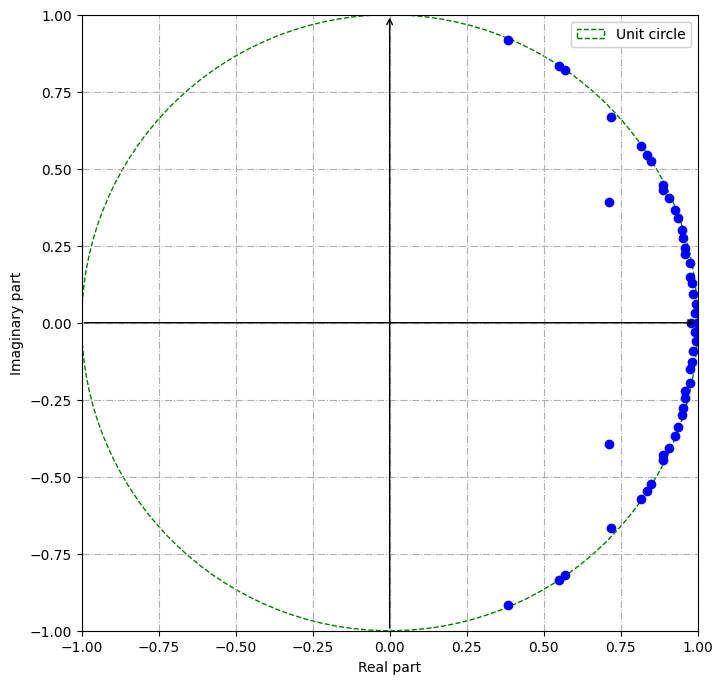

In [308]:
plot_eigs(hodmd)

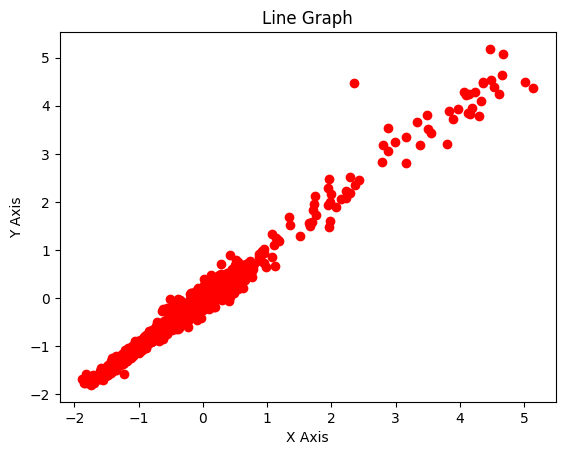

In [309]:
plt.title("Line Graph")
plt.xlabel("X Axis")
plt.ylabel("Y Axis")

plt.scatter(recons[0,:], dmd_data_train[:], color="red")  # note a[0] instead of a
plt.show() 

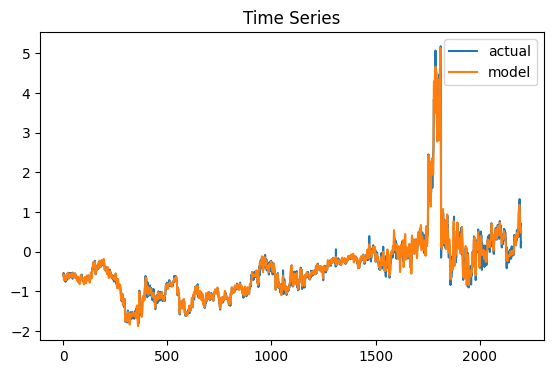

In [310]:
fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(np.arange(0,len(dmd_data_train[:])), dmd_data_train[:], label="actual")
ax.plot(np.arange(0,len(dmd_data_train[:])), recons[0,:], label="model")
ax.set_title("Time Series")
ax.legend()


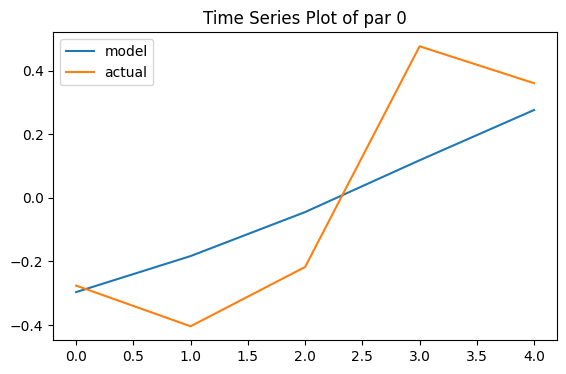

In [317]:
n=2000
n_1=2005

fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(np.arange(0,len(plot_h[0,n:n_1])), plot_h[0,n:n_1], label="model")
#ax.plot(np.arange(0,len(df)), df.to_numpy()[:,0], label="actual")
ax.plot(np.arange(0,len(dmd_data[n:n_1])),dmd_data[n:n_1], label="actual")
ax.set_title("Time Series Plot of par 0")
ax.legend()

In [397]:
from pydmd.preprocessing import hankel_preprocessing

In [520]:
def hodmd_predict(dmd_data,look_back,d=len(dmd_data)):
    
    dmd = HODMD(svd_rank=0, exact=False, opt=True,d=d-150)
    hodmd = hankel_preprocessing(dmd, d=5)
    hodmd.fit(dmd_data[None])
    x = np.arange(0,len(dmd_data))
    hodmd.original_time["dt"] = hodmd.dmd_time["dt"] = x[1] - x[0]
    hodmd.original_time["t0"] = hodmd.dmd_time["t0"] = x[0]
    hodmd.original_time["tend"] = hodmd.dmd_time["tend"] = x[-1]
    hodmd.dmd_time["tend"] = x[-1]+look_back
    data_recons = hodmd.reconstructed_data.real
    return [data_recons[0,-1]]

In [521]:
forecast

[0.6069371281255127]

In [522]:
yhat_DMD = []
yhat_DMD_mse = []
data = lstm_pair_data['Spread_Close'].values
for i in range(train_size+dev_size, len(lstm_pair_data)-1):
    temp_data = data[:i].transpose()
    forecast = hodmd_predict(temp_data,1,d=len(temp_data))
    yhat_DMD.append(forecast[0])
    temp= []
    for j in range(len(forecast)):
        temp.append(forecast[j])
    yhat_DMD_mse.append(np.array(temp))
mse = 0.0
mse = acc_metric(testY_untr, yhat_DMD_mse)
mse

0.2036129391586947

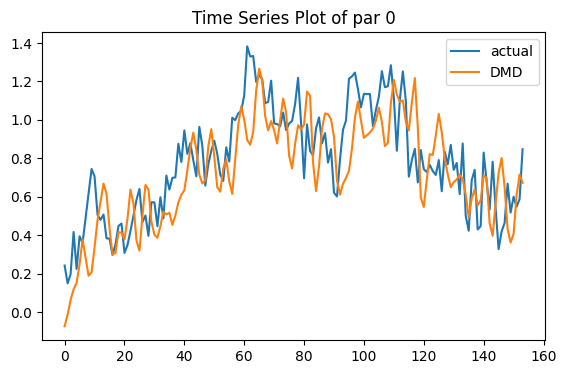

In [523]:
fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(np.arange(0,len(testY_untr)), testY_untr, label="actual")
#ax.plot(np.arange(0,len(yhat_ARIMA)), yhat_ARIMA, label="ARIMA")
#ax.plot(np.arange(0,len(df)), df.to_numpy()[:,0], label="actual")
ax.plot(np.arange(0,len(yhat_DMD_mse)),yhat_DMD_mse, label="DMD")
ax.set_title("Time Series Plot of par 0")
ax.legend()

In [2]:
def trade(S1, S2, spread, window1, window2):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    # Compute rolling mean and rolling standard deviation
    ma1 = spread.rolling(window=window1, center=False).mean()
    ma2 = spread.rolling(window=window2, center=False).mean()
    std = spread.rolling(window=window2, center=False).std()
    zscore = ((ma1 - ma2)/std).to_numpy()
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    print(len(zscore))

    ratio = S1/S2

    for i in range(len(spread)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            money += S1.iloc[i] - S2.iloc[i] * ratio.iloc[i]
            countS1 -= 1
            countS2 += spread.iloc[i]
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:
            money -= S1.iloc[i] - S2.iloc[i] * ratio.iloc[i]
            countS1 += 1
            countS2 -= spread.iloc[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.5:
            money += countS1 * S1.iloc[i] - S2.iloc[i] * countS2
            countS1 = 0
            countS2 = 0
    print(countS1)
    print(countS2)
    return money

In [3]:
test_data = pd.DataFrame({'S1':pair_data['S1_close'].iloc[-len(testX):],'S2':pair_data['S2_close'].iloc[-len(testX):]})
test_data['ARIMA_Predicted_Spread']  = yhat_ARIMA
test_data['DMD_Predicted_Spread']  = yhat_DMD
test_data['Actual_Spread'] = testY_untr #pair_data['Spread_Close'].iloc[-len(testX):]

NameError: name 'pd' is not defined

In [656]:
actual_data = test_data['Actual_Spread']
profit = trade(test_data['S1'], test_data['S2'],actual_data, 30, 5)
profit

154
0
0


array([3422.25667749])

In [657]:
actual_data = test_data['ARIMA_Predicted_Spread']
profit = trade(test_data['S1'], test_data['S2'], actual_data, 30, 5)
profit

154
-4
2.2631169112212257


4493.875889299663

In [658]:
actual_data = test_data['DMD_Predicted_Spread']
profit = trade(test_data['S1'], test_data['S2'], actual_data, 30, 5)
profit

154
-1
0.6091705805388867


5595.089701620503

In [547]:
def trade(S1, S2, window1, window2):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.5:
            money += countS1*S1[i] + S2[i] * countS2
            countS1 = 0
            countS2 = 0
#         print('Z-score: '+ str(zscore[i]), countS1, countS2, S1[i] , S2[i])
    return money